## Kreuzvalidierung
Die Aufteilung in Trainingsmenge und Testmenge bedeutet, dass nur ein Teil der Lernmenge für das Training zur Verfügung steht.
Insbesondere bei kleinen Datenmengen ist das kritisch, da die Aufteilung einen starken Einfluss auf das Ergebnis hat.
Wenige Elemente können einen großen Einfluss auf das Ergebnis haben.
Dies wurde in ML03b-Entscheidungsbaum bereits demonstriert. 

Die **Kreuzvalidierung** (*cross validation*, **CV**) kann diese Situation verbessern.

### 1 $k$-Teilmengen Kreuzvalidierung
Bei einer einzelnen Aufteilung der Daten kann das Ergebnis unter- oder überbewertet werden.
Also eine Leistung, beispielsweise die Kennzahl für die Genauigkeit, liefern große Unterschied 
im Vergleich zur Kennzahl bei einer anderen Aufteilung.
Ziel ist es, eine Abschätzung für die typische, durchschnittliche Leistung zu erzielen.
Auch eine Abschätzung zur Unsicherheit der Leistung, soll erzielt werden.

Bei einer Aufteilung wird ein Teil der Lernmenge nicht in das Training mit einbezogen.
Das ist schlecht, wenn es nur wenige Daten gibt oder es zu aufwändig ist, mehr Daten zu erhalten.
Bei der Kreuzvalidierung werden verschiedene Aufteilungen vorgenommen, 
so dass die Aufteilung in Trainingsmenge / Testmenge sich verändert. 
Mit jeder Aufteilung wird das Training, die Vorhersage und die Bewertung durchgeführt.
Die übergeordnete Bewertung ist dann der Mittelwert (oder der Median) der einzelnen Bewertungen.
Als Streuparameter kann die Standardabweichung (oder die Interquartialsdifferenz) gewählt werden.

#### Wie wird die Kreuzvalidierung durchgeführt?
Die Lernmenge wird in $k$ (möglichst gleich große) Teilmengen unterteilt.
Es werden dann $k$ Iterationen durchgeführt.
In jeder Iteration ist jeweils eine der $k$ Teilmengen die Testmenge,
die anderen Teilmengen bilden zusammen die Trainingsmenge.
Somit besteht die Trainingsmenge aus den $(k-1)$ Teilmengen, welche nicht die Traininhgsmenge ist.
Damit ist jede Teilmenge und jedes einzelne Element genau einmal in der Testmenge und $(k-1)$-Mal in der Trainingsmenge.
Da die Teilmengen in etwa gleich groß sind, haben alle Ergebnisse das gleiche Gewicht.

Im nachfolgenden Bild ist die Aufteilung in fünf Teilmengen dargestellt. 
In jedem der fünf Durchläufe ist eine der fünf Teilmengen die Testmenge, die anderen die Trainingsmenge.

<img src="ExampleCrossValidation.png" style="zoom:60%;" /> 

**Wichtig**: Insbesondere bei schlecht ausgewogenen Lernmengen ist es wichtig, dass die einzelnen Teilmengen in etwa
dieselbe Verteilung der Klassen haben, wie die Gesamtmenge. 
Dies kann zum einen erzielt werden, wenn die Teilmengen per Zufall zusammengesetzt werden.
Zum anderen kann die Lernmenge am Beginn gut durchmischt (*shuffle*)werden. Dann kann die Lernmenge segmentiert werden.
Es kann ach so durchgeführt werden, dass sichergestelt wird, dass alle Teilmengen die gleiche Verteilung haben.
Dieses Vorgehen wird **Schichtenbildung** (*stratification*) genannt.

Es werden dann insgesamt $k$ Vorhersagen durchgeführt und $k$ Kennzahlen ermittelt.
Welche ist die beste oder die richtige Kennzahl? Keine davon!
Aus den $k$ Kennzahlen wird ein Schätzer für die erwartete Kennzahl und die Unsicherheit 
für die Generalisierung berechnet.
Das entgültige Modell wird aus der gesamten Lernmenge gebildet.

#### Wie viele Teilmengen sollen gebildet werden?
Wenn ein großer Wert von $k$ gewählt wird, dann gibt es Vor- und Nachteile:
- Nachteil: der Zeitaufwand steigt linear mit der Anzahl von $k$, denn es werden $k$ Durchläufe abgewickelt.
- Vorteil: Die Abschätzung der Parameter wird zuverlässiger, da die statistische Unsicherheit sinkt.
- Vorteil: Der Generalisierungsfehler entspricht in etwa dem, was im CV-Prozess berechnet wird.

Daher ist die Wahl des geeigneten $k$ eine Abwägung zwischen Verbesserung der Genauigkeit durch mehr Wiederholungen
und der dabei benötigten Rechenzeit.
Typische Werte sind 5 - 10. Es sollte nicht unter 3 gehen.

**Spezialfall** 
Bei der **Leave-One-Out Kreuzvalidierung** (*Leave-One-Out Cross Validation*, **LOO-CV**) werden so viele Iterationen durchgeführt,
wie es Elemente in der Lernmenge gibt. Somit ist bei jedem Durchlauf nur ein einizges Element in der Testmenge.
Bei der **Leave-p-Out Kreuzvalidierung** (*Leave-p-Out Cross Validation*, **LpO-CV**) werden $p$ Elemente in die Testmenge gestellt,
die anderen Element sind in der Trainingsmenge.

### 2 Beispiel: Habitable Planenten - Entscheidungsbaum
Dieses Vorgehen wird nun an der Lernmenge der habitablen Planten durchgeführt. 
Es sind die Daten, die bereits in ML03b-Bewertung verwendet wurden. 

In [1]:
# --- imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# --- read the data - complete
### Die Pfadangabe kann abhängig vom Betriebssystem Probleme machen
### bei Windows okay, bei Linux ? bei MacOS? --> Testen mit Linux
filename = "data/HabitablePlanets_work.csv"
hwc = np.genfromtxt (filename, delimiter=',', \
                     usecols = (1, 2, 3, 4), skip_header = 1)
print (f"number of               exoplanets in the list : {hwc.shape [0]:5d}")

# -- split in features and label
hwc_features = hwc [:,0:3]
hwc_label = hwc [:,3]
unique, counts = np.unique (hwc_label, return_counts = True)
print (f"number of not habitable exoplanets in the list : {counts [0]:5d}")
print (f"number of     habitable exoplanets in the list : {counts [1]:5d}")

number of               exoplanets in the list :  5350
number of not habitable exoplanets in the list :  5280
number of     habitable exoplanets in the list :    70


Es werden $k = 5$ Teilmengen gebildet. Es werden nun drei verschiedene Varianten demonstriert.
Die Aufteilung wird mit hilfe von `sklearn` realisiert. 
Es werden auch die Verteilungen von nicht habitablen und habitablen Planeten in den jeweiligen Teilmengen dargestellt.

In [3]:
# --- imports
from sklearn.model_selection import KFold, StratifiedKFold

# --- set parameters for all variants!
k_splits = 5
random_state = 2024

# --- routine to show distribution of data
def print_distribution (train, test, label):
    n_train_hab = np.sum (label [train])
    n_train_non = train.size - n_train_hab
    n_test_hab = np.sum (label [test])
    n_test_non = test.size - n_test_hab
    print (f" train: [{n_train_non:5.0f} - {n_train_hab:3.0f}]" + \
           f"   test: [{n_test_non:5.0f} - {n_test_hab:3.0f}]")

Variante 1: Standardversion, ohne mischen der Daten.
Die Reihenfolge der Daten bleibt erhalten.
Die Daten sind nicht so ganz gleichmäßig verteilt, aber nicht so schlimm.

Im Exremfall, wenn alle habitablen Planeten hintereinander aufgeführt sind, dann sind alle in einer Teilmenge. 
In den anderen Teilmengen dann keine habitablen Planeten.
Dies führt zu schlechten Ergebnissen.

In [4]:
cv1 = KFold (n_splits = k_splits)

# -- show the distribution
for train, test in cv1.split (hwc_features, hwc_label): 
    print_distribution (train, test, hwc_label)

 train: [ 4221 -  59]   test: [ 1059 -  11]
 train: [ 4225 -  55]   test: [ 1055 -  15]
 train: [ 4229 -  51]   test: [ 1051 -  19]
 train: [ 4227 -  53]   test: [ 1053 -  17]
 train: [ 4218 -  62]   test: [ 1062 -   8]


Variante 2: In dieser Variante, die von Viviana Acquaviva [Acq2023] empfohlen wird, werden die Daten vorher durchmischt.
Hier, bei diesem Beispiel, zeigen sich nur geringe Unterschiede zur Variante 1.

In [5]:
cv2 = KFold (shuffle = True, n_splits = k_splits, random_state = random_state)

# -- show the distribution
for train, test in cv2.split (hwc_features, hwc_label): 
    print_distribution (train, test, hwc_label)

 train: [ 4229 -  51]   test: [ 1051 -  19]
 train: [ 4219 -  61]   test: [ 1061 -   9]
 train: [ 4224 -  56]   test: [ 1056 -  14]
 train: [ 4219 -  61]   test: [ 1061 -   9]
 train: [ 4229 -  51]   test: [ 1051 -  19]


Variante 3: In dieser Variante wird eine Schichtenbildung (*stratification*) durchgeführt. 
Die Menge sind nahezu gleich verteilt und entsprechen der Verteilung in der Gesamtmenge.

In [6]:
cv3 = StratifiedKFold(shuffle = True, n_splits = k_splits, \
                      random_state = random_state)

# -- show the distribution
for train, test in cv3.split (hwc_features, hwc_label): 
    print_distribution (train, test, hwc_label)

 train: [ 4224 -  56]   test: [ 1056 -  14]
 train: [ 4224 -  56]   test: [ 1056 -  14]
 train: [ 4224 -  56]   test: [ 1056 -  14]
 train: [ 4224 -  56]   test: [ 1056 -  14]
 train: [ 4224 -  56]   test: [ 1056 -  14]


Nun wird das Modell Entscheidungsbaum mit den obigen drei verschiedenen Varianten bearbeitet. 
Für jeden der fünf Durchläufe wird jeweils die Genauigkeit berechnet.

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

DT_model = DecisionTreeClassifier()
scores1 = cross_validate (DT_model, hwc_features, hwc_label, cv = cv1, \
                          scoring = 'accuracy')
scores2 = cross_validate (DT_model, hwc_features, hwc_label, cv = cv2, \
                          scoring = 'accuracy')
scores3 = cross_validate (DT_model, hwc_features, hwc_label, cv = cv3, \
                          scoring = 'accuracy')

In der Ausgabe, sind die Trainingszeiten und Vorhersagezeiten je Durchlauf gespeichert.
Ebenso ist die Kennzahl, hier die Genauigkeit der fünf Durchlüufe, gespeichert.

In [8]:
scores1

{'fit_time': array([0.00698256, 0.00697994, 0.00702667, 0.00699687, 0.00703216]),
 'score_time': array([0.0019958 , 0.00099826, 0.00198269, 0.00098062, 0.00098228]),
 'test_score': array([0.98785047, 0.98785047, 0.98130841, 0.98224299, 0.98598131])}

Damit können die Mittelwerte und die Standardabweichungen für die Genauigkeit der drei verschiedenen Varianten berechnet werden.

In [9]:
print (f"variant 1: {scores1 ['test_score'].mean ():5.3f} " \
       + f"+/- {scores1 ['test_score'].std () :5.3f}")
print (f"variant 2: {scores2 ['test_score'].mean ():5.3f} " \
       + f"+/- {scores2 ['test_score'].std () :5.3f}")
print (f"variant 3: {scores3 ['test_score'].mean ():5.3f} " \
       + f"+/- {scores3 ['test_score'].std () :5.3f}")

variant 1: 0.985 +/- 0.003
variant 2: 0.987 +/- 0.003
variant 3: 0.986 +/- 0.002


Die Ergebnisse unterscheiden sich nicht wesentlich von der Genauigkeit beim faulen Modell. 
Es gibt keinen signifikanten Unterschied, da die Abweichungen kleiner als die Standardabweichungen sind.

Jetzt wird als Kennzahl der Trefferquote herangezogen.

In [10]:
scores1 = cross_validate (DT_model, hwc_features, hwc_label, cv = cv1, \
                          scoring = 'recall')
scores2 = cross_validate (DT_model, hwc_features, hwc_label, cv = cv2, \
                          scoring = 'recall')
scores3 = cross_validate (DT_model, hwc_features, hwc_label, cv = cv3, \
                          scoring = 'recall')

print (f"variant 1: {scores1 ['test_score'].mean ():5.3f} " \
       + f"+/- {scores1 ['test_score'].std () :5.3f}")
print (f"variant 2: {scores2 ['test_score'].mean ():5.3f} " \
       + f"+/- {scores2 ['test_score'].std () :5.3f}")
print (f"variant 3: {scores3 ['test_score'].mean ():5.3f} " \
       + f"+/- {scores3 ['test_score'].std () :5.3f}")

variant 1: 0.559 +/- 0.132
variant 2: 0.458 +/- 0.065
variant 3: 0.429 +/- 0.128


Nun wird die Kennzahl für die jeweilige Trainingsmenge betrachtet.
Ausgegeben wird die Trefferquote (nur der Mittelwert) auf der Testmenge und auf der Trainingsmenge.

In [11]:
scores1 = cross_validate (DT_model, hwc_features, hwc_label, cv = cv1, \
                          scoring = 'recall', return_train_score = True)
scores2 = cross_validate (DT_model, hwc_features, hwc_label, cv = cv2, \
                          scoring = 'recall', return_train_score = True)
scores3 = cross_validate (DT_model, hwc_features, hwc_label, cv = cv3, \
                          scoring = 'recall', return_train_score = True)

print (f"variant 1: test {scores1 ['test_score'].mean ():5.3f}   " \
       + f"training {scores1 ['train_score'].mean () :5.3f}")
print (f"variant 2: test {scores2 ['test_score'].mean ():5.3f}   " \
       + f"training {scores2 ['train_score'].mean () :5.3f}")
print (f"variant 3: test {scores3 ['test_score'].mean ():5.3f}   " \
       + f"training {scores3 ['train_score'].mean () :5.3f}")

variant 1: test 0.496   training 1.000
variant 2: test 0.502   training 1.000
variant 3: test 0.443   training 1.000


In [12]:
scores1

{'fit_time': array([0.00697756, 0.00696898, 0.00697994, 0.00699425, 0.00600243]),
 'score_time': array([0.00206757, 0.0030005 , 0.00199652, 0.00298047, 0.00197649]),
 'test_score': array([0.63636364, 0.4       , 0.42105263, 0.64705882, 0.375     ]),
 'train_score': array([1., 1., 1., 1., 1.])}

Wenig überraschend ist die Trefferquote in der Trainingsmenge jeweils 100%.

Damit sind zwar Kennzahlen ermittelt, aber keine Vorhersagen. 
Es gibt in jedem Durchlauf Vorhersagen. Diese können nun verbunden werden.
Damit kann dann die Wahrheitsmatrix erstellt werden.

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn import metrics 

# --- predict
y2_pred = cross_val_predict (DT_model, hwc_features, hwc_label, cv = cv2)

# --- display confusion matrix
metrics.confusion_matrix (hwc_label, y2_pred)

array([[5245,   35],
       [  37,   33]], dtype=int64)

Die Bearbeitung wurde mit fünf Teilmengen durchgeführt.
Die Lernmenge ist ausreichend groß, so dass auch mit zehn Teilmengen das ganze bearbeitet wird.
Als Kreuzvalidation-Methode wird die obige Variante 2 gewählt, also die Daten vorher durchmischt.

In [14]:
k_splits = 10
cv2_10 = KFold (shuffle = True, n_splits = k_splits, \
                random_state = random_state)

# -- show the distribution
for train, test in cv2_10.split (hwc_features, hwc_label): 
    print_distribution (train, test, hwc_label)

# --- cross validation
scores2_10 = cross_validate (DT_model, hwc_features, hwc_label, cv = cv2_10, \
                             scoring = 'recall')

print ()
print (f"10 folds: {scores2_10 ['test_score'].mean ():5.3f} " \
       + f"+/- {scores2_10 ['test_score'].std () :5.3f}")
print (f" 5 folds: {scores2 ['test_score'].mean ():5.3f} " \
       + f"+/- {scores2 ['test_score'].std () :5.3f}")

# --- predict
y2_10_pred = cross_val_predict (DT_model, hwc_features, hwc_label, cv = cv2_10)

# --- display confusion matrix
metrics.confusion_matrix (hwc_label, y2_10_pred)

 train: [ 4756 -  59]   test: [  524 -  11]
 train: [ 4753 -  62]   test: [  527 -   8]
 train: [ 4748 -  67]   test: [  532 -   3]
 train: [ 4751 -  64]   test: [  529 -   6]
 train: [ 4754 -  61]   test: [  526 -   9]
 train: [ 4750 -  65]   test: [  530 -   5]
 train: [ 4749 -  66]   test: [  531 -   4]
 train: [ 4750 -  65]   test: [  530 -   5]
 train: [ 4754 -  61]   test: [  526 -   9]
 train: [ 4755 -  60]   test: [  525 -  10]

10 folds: 0.490 +/- 0.227
 5 folds: 0.502 +/- 0.104


array([[5245,   35],
       [  33,   37]], dtype=int64)

### Lernkurve
Wie verändert sich der Parameter Trefferquote, wenn die Größe der Trainingsmenge wächst?
Auch dazu bietet `sklearn` eine Funktion an.
Dabei wird die Größe der Trainingsmenge verändert (Parameter `train_size`).

TODO: ShuffleSplit genauer kennen lernen, was macht es?

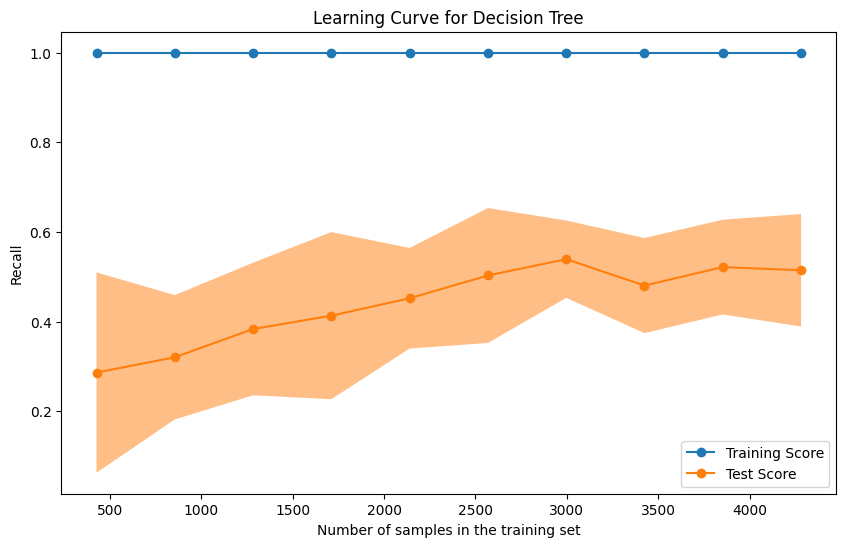

In [15]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
common_params = {
    "X": hwc_features,
    "y": hwc_label,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": ShuffleSplit(n_splits=10, test_size=0.2, random_state=2024),
    "scoring": "recall",
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Recall",
}

LearningCurveDisplay.from_estimator (DT_model, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend (handles[:2], ["Training Score", "Test Score"])
ax.set_title (f"Learning Curve for Decision Tree")
plt.show ()

## Literatur
- [Acq2023] Viviana Acquaviva; Machine Learning for Physics and Astronomy; Princeton University Press; 2023
- [Van2024] Jake VanderPlas; Handbuch Data Science mit Python; O'Reilly; 2024; (Übersetzung der 2. Auflage von *Python Data Science Handbook*)